In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import obspy
import obspy as obs
from obspy import read, read_inventory
from obspy.core.inventory.channel import Channel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
import math
import scipy.signal as sp
from obspy import Stream
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import OSM
from obspy.core.util import get_example_file
from itertools import combinations
import pyproj
from obspy import Stream


In [3]:
def ll_to_utm(latitude, longitude):
    """Convert latitude and longitude coordinates to UTM 32 coordinates"""
    utm_projection = pyproj.Proj(proj="utm", zone=32, ellps="WGS84", datum="WGS84")
    utm_easting, utm_northing = utm_projection(longitude, latitude)
    return utm_easting, utm_northing

def utm_to_ll(utm_easting, utm_northing):
    """Converts UTM32 coordinates to latitude and longitude coordinates"""
    utm_projection = pyproj.Proj(proj="utm", zone=32, ellps="WGS84", datum="WGS84")
    longitude, latitude = utm_projection(utm_easting, utm_northing, inverse=True)
    return latitude, longitude


def clipping(st_filtered,threshold_amplitude=None,clip_factor=None):
    """Performs clipping either at a provided threshold value if threshold_amplitude is not None or
    based on clip_factor*standard deviation of the trace if clip_factor is not None"""
    
    st_clipped = Stream()
    
    if threshold_amplitude is not None and clip_factor is None:
        for trace in st_filtered:
            trace_clipped = trace.copy()
            trace_clipped.data[trace_clipped.data > threshold_amplitude] = threshold_amplitude
            trace_clipped.data[trace_clipped.data < -threshold_amplitude] = -threshold_amplitude
            st_clipped.append(trace_clipped)

    elif clip_factor is not None and threshold_amplitude is None:
        for trace in st_filtered:
            lim = clip_factor * np.std(trace.data)
            trace_clipped = trace.copy()
            trace_clipped.data[trace_clipped.data > lim] = lim
            trace_clipped.data[trace_clipped.data < -lim] = -lim
            st_clipped.append(trace_clipped)

    elif clip_factor is None and threshold_amplitude is None:
        return st_filtered
    else:
        raise ValueError("Either threshold_amplitude or clip_factor must be specified.")

    return st_clipped


def MakeMyFig(st,acc='S'):
    """ Plots the traces organized by node number
    st : stream containing the traces
    acc : accuracy of the time either S to go up to seconds or f to show milliseconds
    """
    plt.close('all')
    plt.figure(figsize=(14,5))
    min_time = UTCDateTime(2025,1,1)
    max_time = UTCDateTime(1999,1,1)

    for i in range(len(st)):
        tr = st[i].data/(2*np.max(np.abs(st[i].data)))
        time = st[i].times('timestamp')
        node_number = int(st[i].stats.station)
        plt.plot(time,tr+node_number)
        if st[i].stats.starttime < min_time:
            min_time = st[i].stats.starttime
        if st[i].stats.endtime > max_time:
            max_time = st[i].stats.endtime

    timestamps = np.linspace(min_time.timestamp,max_time.timestamp,5)
    timeticks = []
    for i in range(len(timestamps)):
        if acc=='S':
            timeticks.append(UTCDateTime(timestamps[i]).strftime('%H:%M:%S'))
        elif acc=='f':
            timeticks.append(UTCDateTime(timestamps[i]).strftime('%H:%M:%S.%f'))
        
    plt.title('Section organized by node number')
    plt.ylabel('Node number')
    plt.xlabel('time')
    plt.xlim(timestamps[0],timestamps[-1])
    plt.xticks(timestamps, timeticks);


## Read and clean nodes  metadata

In [4]:
nodes_metadata = pd.read_csv('NodesCoordinates.csv')

# Step 2: Clean nodes_metadata
nodes_metadata = nodes_metadata.drop(2) # dropping the erroneous value
nodes_metadata = nodes_metadata.dropna(subset=['RU Position Easting']) # dropping rows with NaN values
nodes_metadata = nodes_metadata.groupby('Point #')[['RU Position Easting', 'RU Position Northing']].mean() # averaging
nodes_metadata = nodes_metadata.reset_index()


## Read Source metadata

In [5]:
def dms_to_decimal(degrees, minutes, seconds, direction):
    sign = 1 if direction in ['N', 'E'] else -1
    return sign * (abs(degrees) + minutes / 60 + seconds / 3600)

def ll_to_utm(latitude, longitude):
    """Convert latitude and longitude coordinates to UTM 32 coordinates"""
    utm_projection = pyproj.Proj(proj="utm", zone=32, ellps="WGS84", datum="WGS84")
    utm_easting, utm_northing = utm_projection(longitude, latitude)
    return utm_easting, utm_northing

# DMS coordinates
coordinates_dms = [
    {'code': 'S1', 'lat_deg': 44, 'lat_min': 57, 'lat_sec': 23.28, 'lat_dir': 'N', 'lon_deg': 5, 'lon_min': 35, 'lon_sec': 16.20, 'lon_dir': 'E'},
    {'code': 'S2', 'lat_deg': 44, 'lat_min': 57, 'lat_sec': 22.99, 'lat_dir': 'N', 'lon_deg': 5, 'lon_min': 35, 'lon_sec': 16.20, 'lon_dir': 'E'},
    {'code': 'S3', 'lat_deg': 44, 'lat_min': 57, 'lat_sec': 23.56, 'lat_dir': 'N', 'lon_deg': 5, 'lon_min': 35, 'lon_sec': 16.55, 'lon_dir': 'E'},
    {'code': 'S4', 'lat_deg': 44, 'lat_min': 57, 'lat_sec': 23.32, 'lat_dir': 'N', 'lon_deg': 5, 'lon_min': 35, 'lon_sec': 17.05, 'lon_dir': 'E'},
    {'code': 'S5', 'lat_deg': 44, 'lat_min': 57, 'lat_sec': 23.17, 'lat_dir': 'N', 'lon_deg': 5, 'lon_min': 35, 'lon_sec': 17.61, 'lon_dir': 'E'}
]
# Convert DMS to decimal degrees
coordinates_decimal = []
for coord in coordinates_dms:
    lat_decimal = dms_to_decimal(coord['lat_deg'], coord['lat_min'], coord['lat_sec'], coord['lat_dir'])
    lon_decimal = dms_to_decimal(coord['lon_deg'], coord['lon_min'], coord['lon_sec'], coord['lon_dir'])
    coordinates_decimal.append({'code': coord['code'], 'lat': lat_decimal, 'lon': lon_decimal})

# Write the decimal coordinates to a new CSV file
decimal_df = pd.DataFrame(coordinates_decimal)
decimal_df.to_csv('DecimalCoordinates.csv', index=False)

# Convert decimal coordinates to UTM and overwrite Sources.csv
utm_coordinates = []
for index, row in decimal_df.iterrows():
    utm_easting, utm_northing = ll_to_utm(row['lat'], row['lon'])
    utm_coordinates.append({'code': row['code'], 'northing': utm_northing, 'easting': utm_easting})

utm_df = pd.DataFrame(utm_coordinates)
utm_df.to_csv('Sources.csv', index=False)


In [6]:
sources_metadata = pd.read_csv('Sources.csv')


In [52]:
print(sources_metadata)

  code      northing        easting
0   S1  4.983780e+06  230865.078690
1   S2  4.983771e+06  230864.701694
2   S3  4.983789e+06  230873.111106
3   S4  4.983781e+06  230883.754016
4   S5  4.983776e+06  230895.828526


In [53]:
print(nodes_metadata)

    Point #  RU Position Easting  RU Position Northing
0         1            230858.10            4983795.90
1         2            230866.00            4983795.95
2         3            230875.45            4983799.20
3         4            230883.15            4983795.05
4         5            230859.90            4983775.40
5         6            230867.20            4983774.60
6         7            230858.85            4983786.40
7         8            230864.95            4983786.30
8         9            230872.30            4983787.95
9        10            230882.35            4983786.05
10       11            230873.10            4983775.15
11       13            230859.50            4983760.05
12       14            230869.25            4983761.35
13       15            230872.75            4983762.10
14       16            230879.10            4983761.75


## Step 3: Convert coordinates to latitude and longitude


In [7]:
sources_lat, sources_lon = utm_to_ll(sources_metadata['easting'], sources_metadata['northing'])
nodes_lat, nodes_lon = utm_to_ll(nodes_metadata['RU Position Easting'], nodes_metadata['RU Position Northing'])
print(nodes_lat, nodes_lon)
print(sources_lat, sources_lon)

[44.95660499 44.95660843 44.95664121 44.95660683 44.95642145 44.95641703
 44.9565199  44.95652131 44.95653892 44.95652565 44.9564242  44.95628337
 44.95629874 44.9563068  44.95630606] [5.58773665 5.5878366  5.58795447 5.58805413 5.58777036 5.58786317
 5.58775121 5.58782846 5.5879206  5.5880488  5.58793755 5.58777348
 5.58789618 5.58794008 5.58802063]
[44.95646667 44.95638611 44.95654444 44.95647778 44.95643611] [5.58783333 5.58783333 5.58793056 5.58806944 5.588225  ]


## Step 4: Plot nodes and sources


In [38]:
pip install contextily


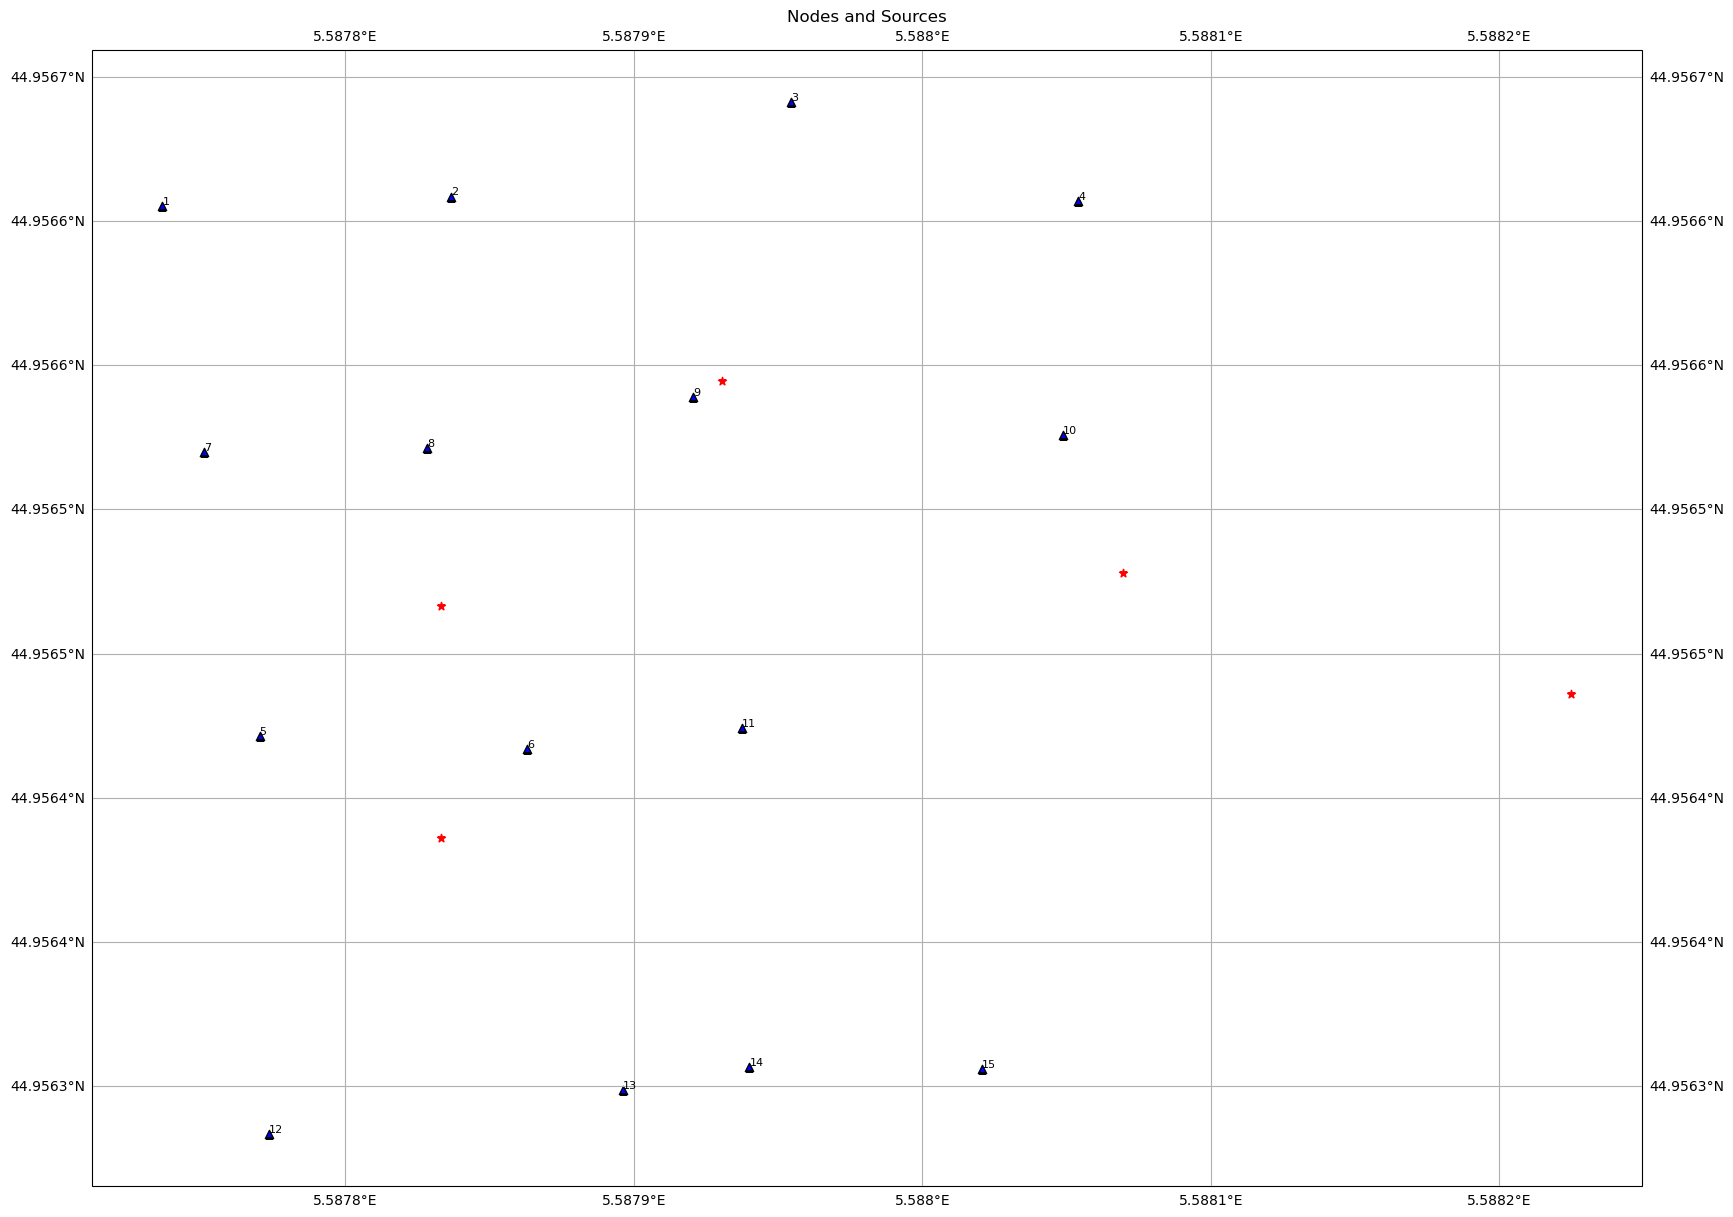

In [73]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot sources as red stars
ax.scatter(sources_lon, sources_lat, color='red', edgecolors='red', marker='*', transform=ccrs.PlateCarree())

# Plot nodes as blue triangles
ax.scatter(nodes_lon, nodes_lat, color='blue', edgecolors='black', marker='^', transform=ccrs.PlateCarree())

# Annotate nodes with their numbers
for i, (lat, lon) in enumerate(zip(nodes_lat, nodes_lon)):
    ax.text(lon, lat, str(i+1), color='black', fontsize=8, transform=ccrs.PlateCarree(), va='bottom')

# Customize plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Nodes and Sources')
ax.gridlines(draw_labels=True)
ax.coastlines()
plt.show()

# Reading the data

In [8]:
import os

current_directory = os.getcwd()

datadirectory = os.path.join(current_directory, '1', '1')

print(datadirectory)  

time = 1
channel = 'DP4'
st = Stream()

nodes_number = nodes_metadata['Point #']

for sta in nodes_number:
    try:
        if time == 1 and sta == 2:
            st_tmp = obspy.read(f'{datadirectory}/{sta}.2.0.fcnt')
        else:
            st_tmp = obspy.read(f'{datadirectory}/{sta}.{time}.0.fcnt')
        
        for tr in st_tmp.select(channel=channel):
            st.append(tr)
    except FileNotFoundError:
        print(f"File not found for station {sta}")
    except Exception as e:
        print(f"An error occurred for station {sta}: {e}")

st.detrend('demean')
st.detrend('linear')


C:\Users\Utilisateur\OneDrive\Desktop\Masters_GAEI\instrumentation\new_florent\1\1


15 Trace(s) in Stream:
1.1.1.DP4  | 2024-03-06T13:22:56.728000Z - 2024-03-06T14:22:56.724000Z | 250.0 Hz, 900000 samples
1.2.1.DP4  | 2024-03-06T13:18:30.320000Z - 2024-03-06T14:18:30.316000Z | 250.0 Hz, 900000 samples
1.3.1.DP4  | 2024-03-06T13:18:32.744000Z - 2024-03-06T14:18:32.740000Z | 250.0 Hz, 900000 samples
1.4.1.DP4  | 2024-03-06T13:10:06.908000Z - 2024-03-06T14:10:06.904000Z | 250.0 Hz, 900000 samples
1.5.1.DP4  | 2024-03-06T13:22:58.840000Z - 2024-03-06T14:22:58.836000Z | 250.0 Hz, 900000 samples
1.6.1.DP4  | 2024-03-06T13:19:42.480000Z - 2024-03-06T14:19:42.476000Z | 250.0 Hz, 900000 samples
1.7.1.DP4  | 2024-03-06T13:22:30.484000Z - 2024-03-06T14:22:30.480000Z | 250.0 Hz, 900000 samples
1.8.1.DP4  | 2024-03-06T13:19:20.916000Z - 2024-03-06T14:19:20.912000Z | 250.0 Hz, 900000 samples
1.9.1.DP4  | 2024-03-06T13:17:38.660000Z - 2024-03-06T14:17:38.656000Z | 250.0 Hz, 900000 samples
1.10.1.DP4 | 2024-03-06T13:13:06.280000Z - 2024-03-06T14:13:06.276000Z | 250.0 Hz, 900000 sampl

## Filtering the data

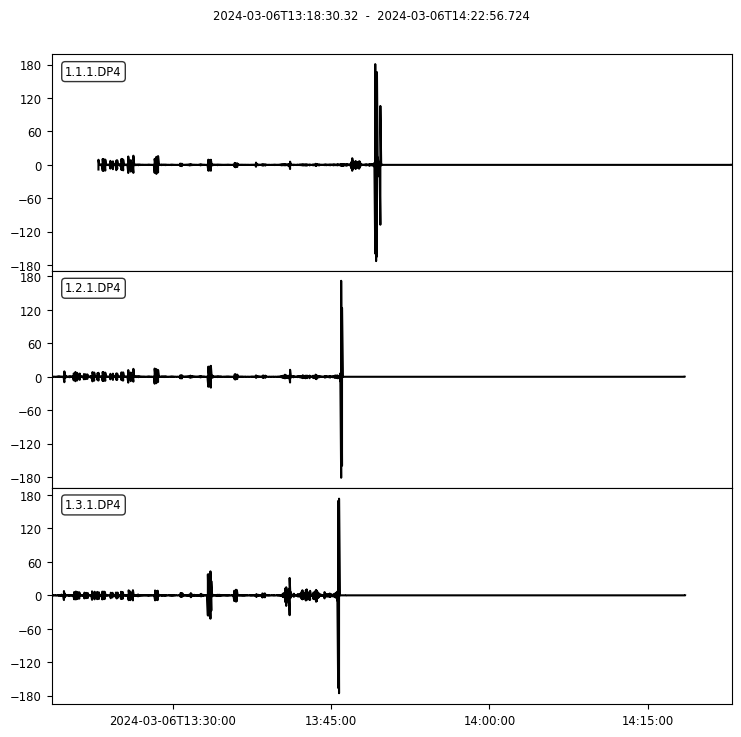

In [9]:
fmin = 1
fmax = 100
st_filtered = st.copy() 
st_filtered.filter('bandpass',freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
st_filtered[0:3].plot();

## Figure of section by Node number

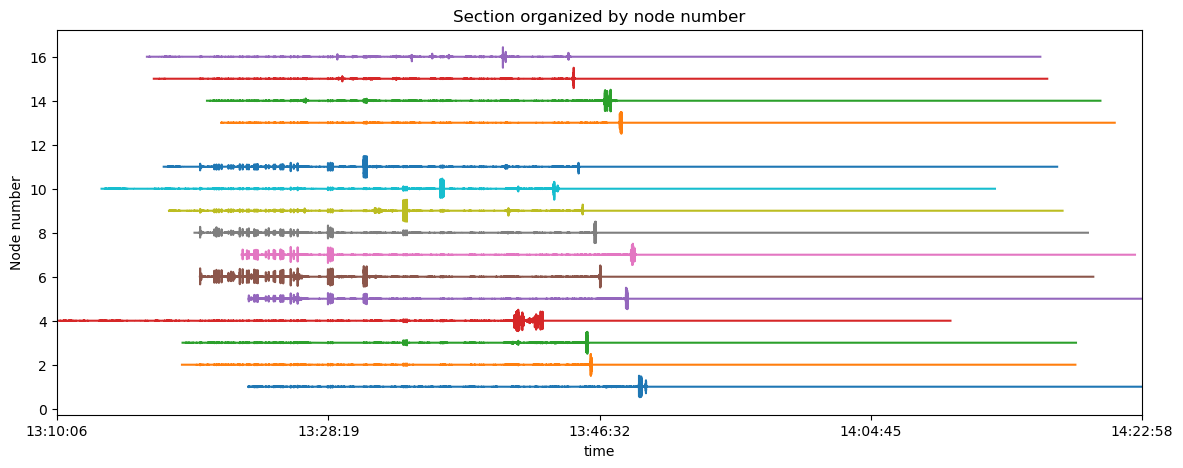

In [18]:
MakeMyFig(st_filtered)

## For each source, the same type of figure is generated . Choose a suitable tir for the source

In [19]:
# First converting my source_metadata
print(sources_lat, sources_lon)

[44.96078889 44.96064444 44.96090833 44.96079722 44.96074167] [5.59083333 5.59089444 5.59099444 5.59122778 5.54148611]


## Each station in their DMS format:

In [10]:
def decimal_degrees_to_dms(deg):
    degrees = int(deg)
    minutes_float = (deg - degrees) * 60
    minutes = int(minutes_float)
    seconds = (minutes_float - minutes) * 60
    return degrees, minutes, seconds

def dms_to_string(degrees, minutes, seconds, direction):
    return f"{direction}{degrees:02d}°{minutes:02d}'{seconds:.4f}\""
sources_lat_dms = [decimal_degrees_to_dms(lat) for lat in sources_lat]
sources_lon_dms = [decimal_degrees_to_dms(lon) for lon in sources_lon]

sources_lat_str = [dms_to_string(deg, minutes, seconds, 'N' if deg >= 0 else 'S') for deg, minutes, seconds in sources_lat_dms]
sources_lon_str = [dms_to_string(deg, minutes, seconds, 'E' if deg >= 0 else 'W') for deg, minutes, seconds in sources_lon_dms]

station_names = ['S1', 'S2', 'S3', 'S4', 'S5']

print("Station\tLatitude\tLongitude")
for name, lat, lon in zip(station_names, sources_lat_str, sources_lon_str):
    print(f"{name}\t{lat}\t{lon}")


Station	Latitude	Longitude
S1	N44°57'23.2800"	E05°35'16.2000"
S2	N44°57'22.9900"	E05°35'16.2000"
S3	N44°57'23.5600"	E05°35'16.5500"
S4	N44°57'23.3200"	E05°35'17.0500"
S5	N44°57'23.1700"	E05°35'17.6100"


In [11]:
coordinates = [
    ("S1", 44.956468, 5.58783333),
    ("S2", 44.95638666, 5.58783333),
    ("S3", 44.956545, 5.58793),
    ("S4", 44.9564783, 5.58807),
    ("S5", 44.956435 ,5.588225)
]

coordinates_dms = []
for name, lat, lon in coordinates:
    lat_d, lat_m, lat_s = decimal_degrees_to_dms(lat)
    lon_d, lon_m, lon_s = decimal_degrees_to_dms(lon)
    coordinates_dms.append((name, (lat_d, lat_m, lat_s), (lon_d, lon_m, lon_s)))

for name, lat_dms, lon_dms in coordinates_dms:
    print(f"{name}: Latitude - {lat_dms[0]}° {lat_dms[1]}' {lat_dms[2]:.2f}\" | Longitude - {lon_dms[0]}° {lon_dms[1]}' {lon_dms[2]:.2f}\"")

S1: Latitude - 44° 57' 23.28" | Longitude - 5° 35' 16.20"
S2: Latitude - 44° 57' 22.99" | Longitude - 5° 35' 16.20"
S3: Latitude - 44° 57' 23.56" | Longitude - 5° 35' 16.55"
S4: Latitude - 44° 57' 23.32" | Longitude - 5° 35' 17.05"
S5: Latitude - 44° 57' 23.17" | Longitude - 5° 35' 17.61"


## First shot at Source found at S1


In [12]:
starttime=UTCDateTime(2024,3,6,13,28,18.5)
endtime=UTCDateTime(2024,3,6,13,28,19.2)

st_filtered_S1=st_filtered.copy()
st_filtered_S1.trim(starttime=starttime, endtime=endtime)


15 Trace(s) in Stream:
1.1.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.2.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.3.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.4.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.5.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.6.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.7.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.8.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.9.1.DP4  | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.10.1.DP4 | 2024-03-06T13:28:18.500000Z - 2024-03-06T13:28:19.200000Z | 250.0 Hz, 176 samples
1.11.1.DP4 | 2024-03-06T13:

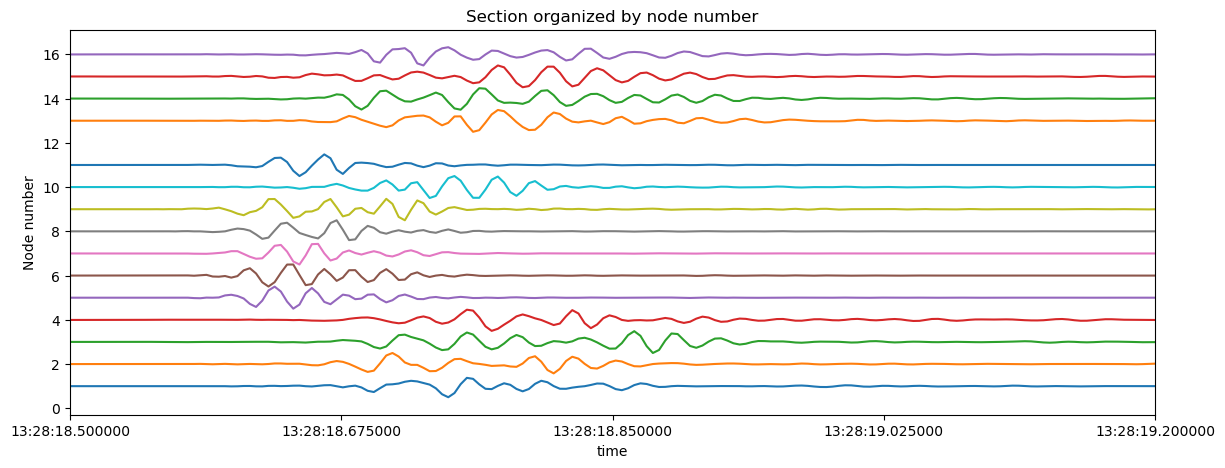

In [59]:
MakeMyFig(st_filtered_S1,acc='f')

## First shot at Source found at  S2


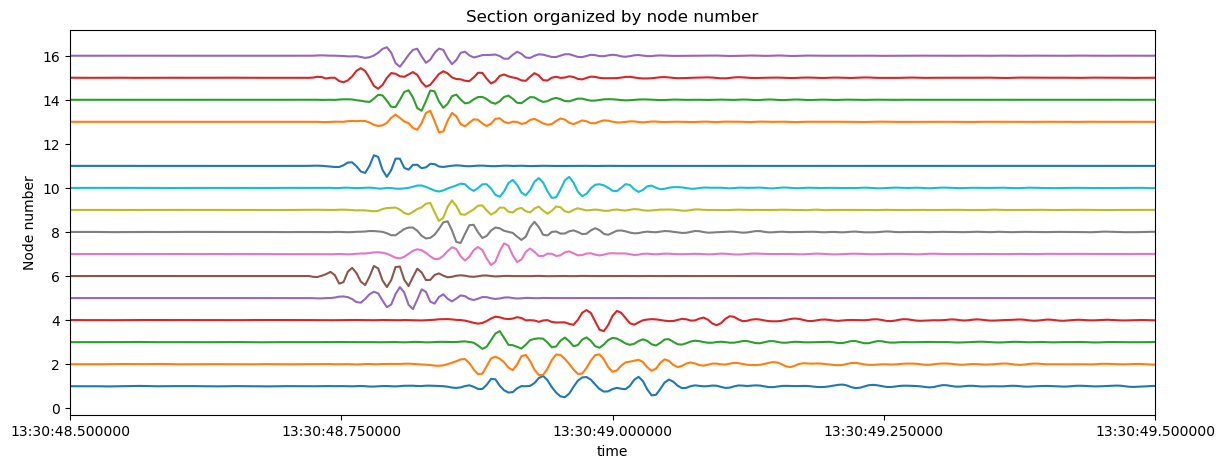

In [23]:
starttime = UTCDateTime(2024,3,6,13,30,48.5)
endtime = UTCDateTime(2024,3,6,13,30,49.5)
st_filtered_S2 = st_filtered.copy()
st_filtered_S2.trim(starttime=starttime, endtime=endtime)
MakeMyFig(st_filtered_S2,acc='f')

## Third shot at Source found at  S3

Plot is seemed to be very noisy. Might be problematic in the next sections. Might be due to external or instrumental noise.
Might be of interest to do an instrumental correction

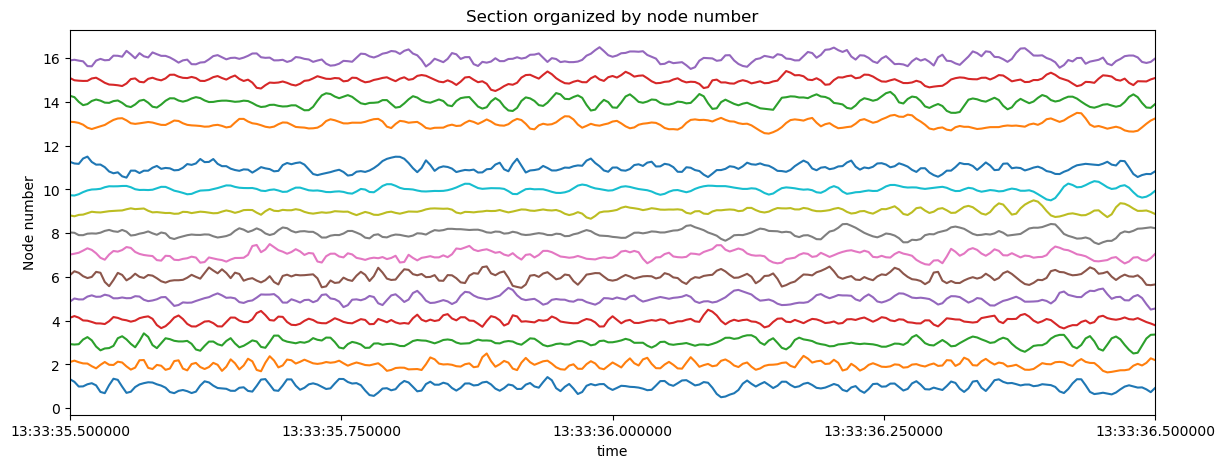

In [24]:
starttime = UTCDateTime(2024,3,6,13,33,35.5)
endtime = UTCDateTime(2024,3,6,13,33,36.5)
st_filtered_S3 = st_filtered.copy()
st_filtered_S3.trim(starttime=starttime, endtime=endtime)

MakeMyFig(st_filtered_S3,acc='f')

## First shot at Source found at  S4
Many nodes did not register much movement. Might be due to their positions being too far from the nodes or the 'tir' not having enough energy.

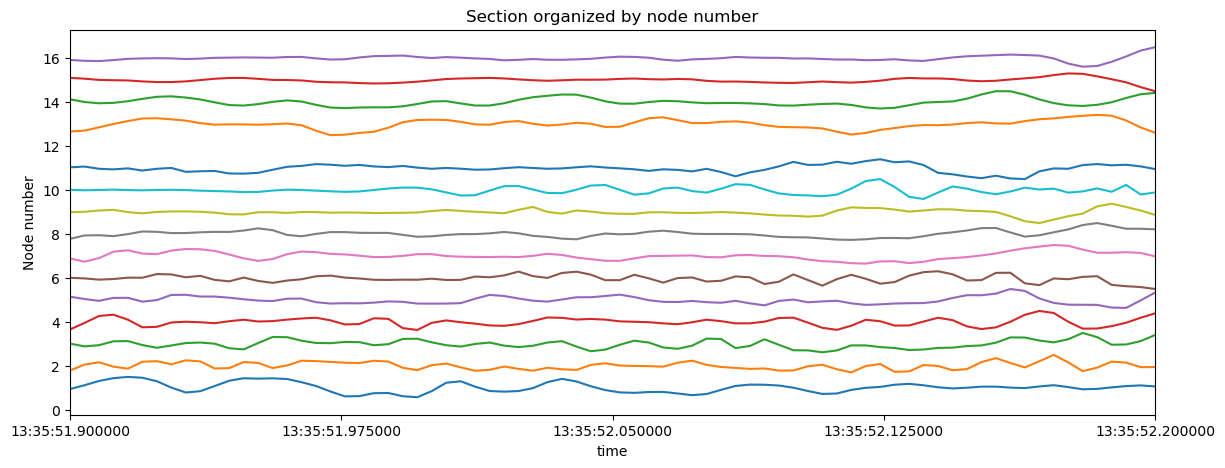

In [240]:
starttime = UTCDateTime(2024,3,6,13,35,51.9)
endtime = UTCDateTime(2024,3,6,13,35,52.2)
st_filtered_S4 = st_filtered.copy()
st_filtered_S4.trim(starttime=starttime, endtime=endtime)

MakeMyFig(st_filtered_S4,acc='f')

## Third shot at Source found at S5


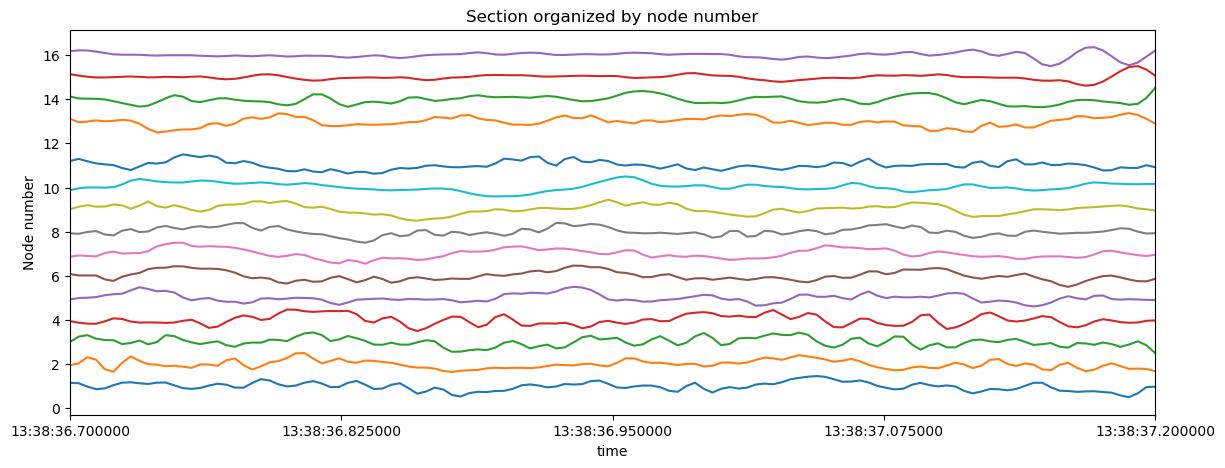

In [244]:
starttime = UTCDateTime(2024,3,6,13,38,36.7)
endtime = UTCDateTime(2024,3,6,13,38,37.2)
st_filtered_S5 = st_filtered.copy()
st_filtered_S5.trim(starttime=starttime, endtime=endtime)

MakeMyFig(st_filtered_S5,acc='f')

## Function to calculate distance from source to nodes

In [13]:
def cal_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [14]:
# Initialize lists to store minimum distances for each source
min_dist_source_1 = []
min_dist_source_2 = []
min_dist_source_3 = []
min_dist_source_4 = []
min_dist_source_5 = []

source_node_mapping = {}  # Dictionary to store the mapping of source to closest node

for index, source_metadata in sources_metadata.iterrows():
    # Extract latitude and longitude of the source
    source_lat, source_lon = sources_lat[index], sources_lon[index]
    
    # Initialize variables to store closest node and minimum distance
    closest_node = None
    min_distance = float('inf')
    
    # Iterate through each node
    for node_lat, node_lon, node_id in zip(nodes_lat, nodes_lon, nodes_metadata['Point #']):
        # Calculate the distance between the source and the node
        distance = cal_distance(source_lat, source_lon, node_lat, node_lon)
        if source_metadata['code'] == 'S1':
            min_dist_source_1.append(distance)
        elif source_metadata['code'] == 'S2':
            min_dist_source_2.append(distance)
        elif source_metadata['code'] == 'S3':
            min_dist_source_3.append(distance)
        elif source_metadata['code'] == 'S4':
            min_dist_source_4.append(distance)
        elif source_metadata['code'] == 'S5':
            min_dist_source_5.append(distance)
        
        # Check if the calculated distance is less than the current minimum distance
        if distance < min_distance:
            min_distance = distance
            closest_node = node_id  # Update closest node ID
    
    # Print the closest node and distance for the current source
    print(f"Closest node to source {source_metadata['code']}: Node {closest_node}, Distance: {min_distance} km")
    
    # Append the minimum distance to the appropriate list based on the source code
    
    
    # Map source name to closest node ID
    source_node_mapping[source_metadata['code']] = closest_node

# Print the source-node mapping dictionary
print(source_node_mapping)

# Accessing just the codes from the source_node_mapping dictionary
node_ids = list(source_node_mapping.values())
print(node_ids)

# Print the minimum distances for each source
print("Minimum distances for each source:")
print("Source 1:", min_dist_source_1)
print("Source 2:", min_dist_source_2)
print("Source 3:", min_dist_source_3)
print("Source 4:", min_dist_source_4)
print("Source 5:", min_dist_source_5)


Closest node to source S1: Node 6, Distance: 0.005998158018751899 km
Closest node to source S2: Node 6, Distance: 0.004163163746009048 km
Closest node to source S3: Node 9, Distance: 0.0009953394234757753 km
Closest node to source S4: Node 10, Distance: 0.005565788392944186 km
Closest node to source S5: Node 10, Distance: 0.017069065253496725 km
{'S1': 6, 'S2': 6, 'S3': 9, 'S4': 10, 'S5': 10}
[6, 6, 9, 10, 10]
Minimum distances for each source:
Source 1: [0.01715906839877713, 0.015764977290776857, 0.021622313111652247, 0.02333992979136538, 0.007058975744546957, 0.005998158018751899, 0.008763711875369189, 0.006088500857793863, 0.010569019814345385, 0.018179062873968685, 0.009462506976557112, 0.0209190056471236, 0.01931636446934993, 0.019660350270507977, 0.023154124263393576]
Source 2: [0.025499084884236693, 0.024721585762456366, 0.029924061099376138, 0.03006987661924949, 0.006324428663579102, 0.004163163746009048, 0.016219873565051612, 0.015038670195593523, 0.018326875626744645, 0.02298

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16156\3722840432.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16156\3722840432.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16156\3722840432.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16156\3722840432.py:56: UserW

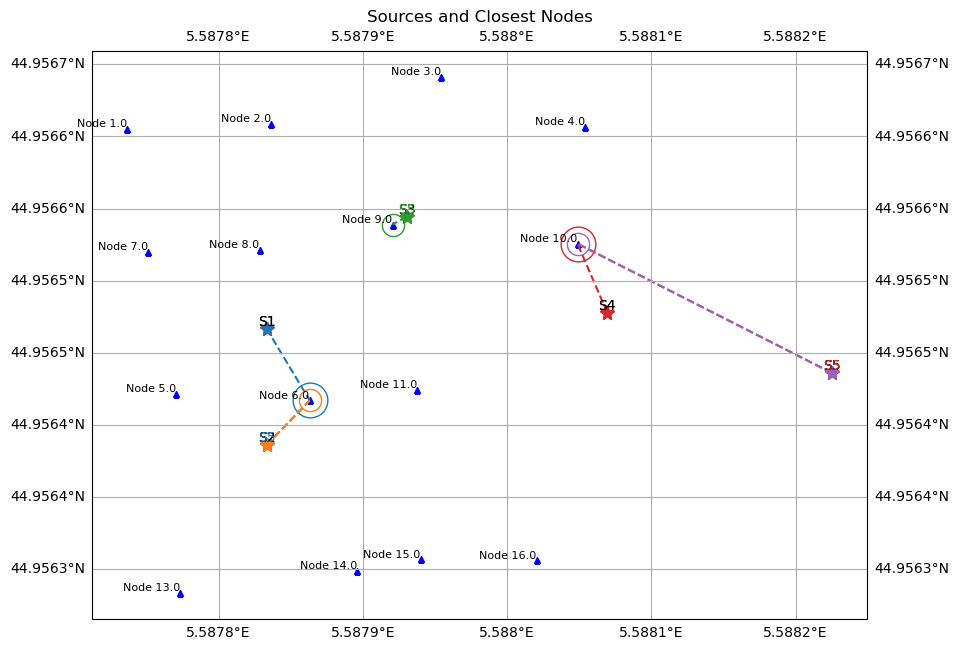

In [129]:
# Plotting
import matplotlib.cm as cm

# Define a color map
colors = cm.tab10.colors  # You can choose any colormap you like

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Count the occurrences of each node in the node_ids list
node_counts = Counter(node_ids)

# Plot sources as stars and annotate them
for source_code, closest_node_id in source_node_mapping.items():
    source_lat, source_lon = sources_lat[int(source_code[1]) - 1], sources_lon[int(source_code[1]) - 1]
    ax.plot(source_lon, source_lat, 'r*', markersize=10)
    ax.text(source_lon, source_lat, source_code, color='black', fontsize=10, ha='center', va='bottom')

# Plot nodes as triangles and annotate them
for index, row in nodes_metadata.iterrows():
    node_id = row['Point #']
    if node_id not in node_ids:
        node_lat, node_lon = utm_to_ll(row['RU Position Easting'], row['RU Position Northing'])
        ax.plot(node_lon, node_lat, 'b^', markersize=5)
        ax.text(node_lon, node_lat, f'Node {node_id}', color='black', fontsize=8, ha='right', va='bottom')
    else: 
        node_lat, node_lon = utm_to_ll(row['RU Position Easting'], row['RU Position Northing'])
        count = node_counts.get(node_id, 0)
        color_index = min(node_ids.index(node_id), len(colors) - 1)  # Ensure color index doesn't exceed colormap length
        color = colors[color_index]
        
        if count == 1:
            ax.plot(node_lon, node_lat, 'b^', markersize=5)
            ax.plot(node_lon, node_lat, 'o', fillstyle='none', markersize=16, color=color)  # Larger circle
            
            for source_code, closest_node_id in source_node_mapping.items():
                if closest_node_id==node_id:
                    station_color = color
                    source_lat, source_lon = sources_lat[int(source_code[1]) - 1], sources_lon[int(source_code[1]) - 1]
                    ax.plot([source_lon, node_lon], [source_lat, node_lat], linestyle='--', color=station_color)  # Dotted line
                    ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
                    ax.text(source_lon, source_lat, source_code, color='black', fontsize=10, ha='center', va='bottom')
        elif count >= 2:
            countsrc=0
            ax.plot(node_lon, node_lat, 'b^', markersize=5)
            # For larger circle
            larger_color_index = min(node_ids.index(node_id), len(colors) - 1)  # Ensure color index doesn't exceed colormap length
            larger_color = colors[larger_color_index]
            ax.plot(node_lon, node_lat, 'o', fillstyle='none', markersize=25, color=larger_color)  # Larger circle
            for source_code, closest_node_id in source_node_mapping.items():
                countsrc = 1
                if closest_node_id==node_id:
                    station_color = larger_color
                    source_lat, source_lon = sources_lat[int(source_code[1]) - 1], sources_lon[int(source_code[1]) - 1]
                    ax.plot([source_lon, node_lon], [source_lat, node_lat], linestyle='--', color=station_color)  # Dotted line
                    ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
                    ax.text(source_lon, source_lat, source_code, color='black', fontsize=10, ha='center', va='bottom')
                    
            
            # For smaller circle
            smaller_color_index = (larger_color_index + 1) % len(colors)  # Choose the next color in the colormap
            smaller_color = colors[smaller_color_index]
            ax.plot(node_lon, node_lat, 'o', fillstyle='none', markersize=16, color=smaller_color)  # Smaller circle
            for source_code, closest_node_id in source_node_mapping.items():
                if closest_node_id==node_id :
                    if countsrc == 1:
                        countsrc+=1
                    else:
                        station_color = smaller_color
                        source_lat, source_lon = sources_lat[int(source_code[1]) - 1], sources_lon[int(source_code[1]) - 1]
                        ax.plot([source_lon, node_lon], [source_lat, node_lat], linestyle='--', color=station_color)  # Dotted line
                        ax.plot(source_lon, source_lat, 'r*', markersize=10, color=station_color)
                        ax.text(source_lon, source_lat, source_code, color='black', fontsize=10, ha='center', va='bottom')
            

        ax.text(node_lon, node_lat, f'Node {node_id}', color='black', fontsize=8, ha='right', va='bottom')
        
        # Annotate stations with the same color as their corresponding nodes
        station_color = color
        ax.text(source_lon, source_lat, f'{source_code}', color=station_color, fontsize=10, ha='center', va='bottom')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Sources and Closest Nodes')
ax.gridlines(draw_labels=True)
ax.coastlines()

# Show the map
plt.show()


## Wave propagation plot

# Source 1

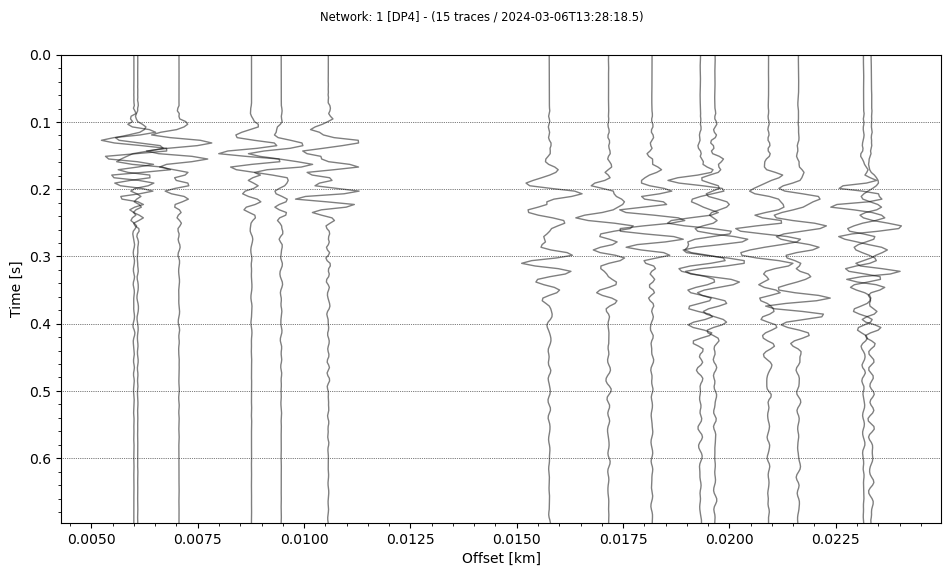

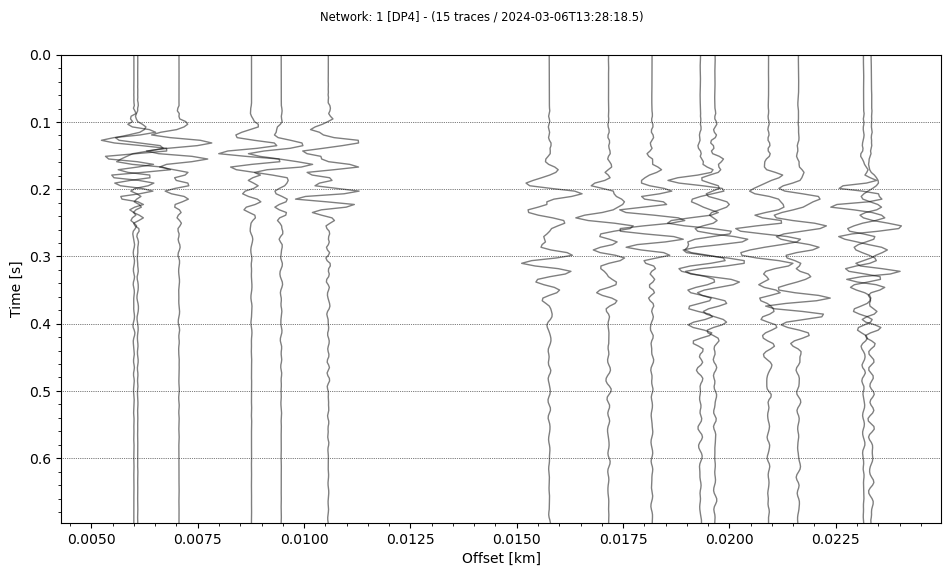

In [15]:

fig_size = (10, 7)  

plt.close('all')

distances = min_dist_source_1

for node_number, tr in enumerate(st_filtered_S1):
    tr.stats.distance = distances[node_number] * 1000

st_filtered_S1.plot(type='section', scale=1.0, alpha=0.5,
                    linewidth=1, color='black', show=True,
                    time_down=True,
                    offset='distance', norm_method='trace',
                    figsize=fig_size)  




In [38]:
import numpy as np


def find_first_arrival(trace):
    data = np.array(trace.data)
    
    
    first_arrival_index = np.argmax(np.abs(data))
    
    first_arrival_time = first_arrival_index / trace.stats.sampling_rate
    
    return first_arrival_time

first_trace = st_filtered_S1[4]
first_arrival_time = find_first_arrival(first_trace)

print(first_arrival_time)

0.132


# Source 2

In [16]:

fig_size = (10, 7)  

plt.close('all')

distances = min_dist_source_2

for node_number, tr in enumerate(st_filtered_S2):
    tr.stats.distance = distances[node_number] * 1000

st_filtered_S2.plot(type='section', scale=1.0, alpha=0.5,
                    linewidth=1, color='black', show=True,
                    time_down=True,
                    offset='distance', norm_method='trace',
                    figsize=fig_size)  

NameError: name 'st_filtered_S2' is not defined

# Source 3

Very noisy. Problematic soruce or might have been too noisy in the surroundings.

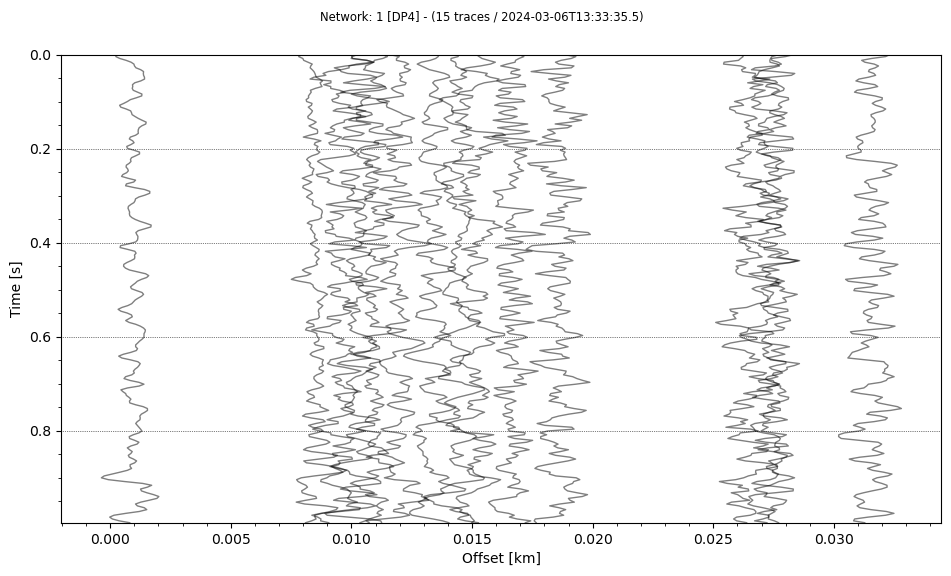

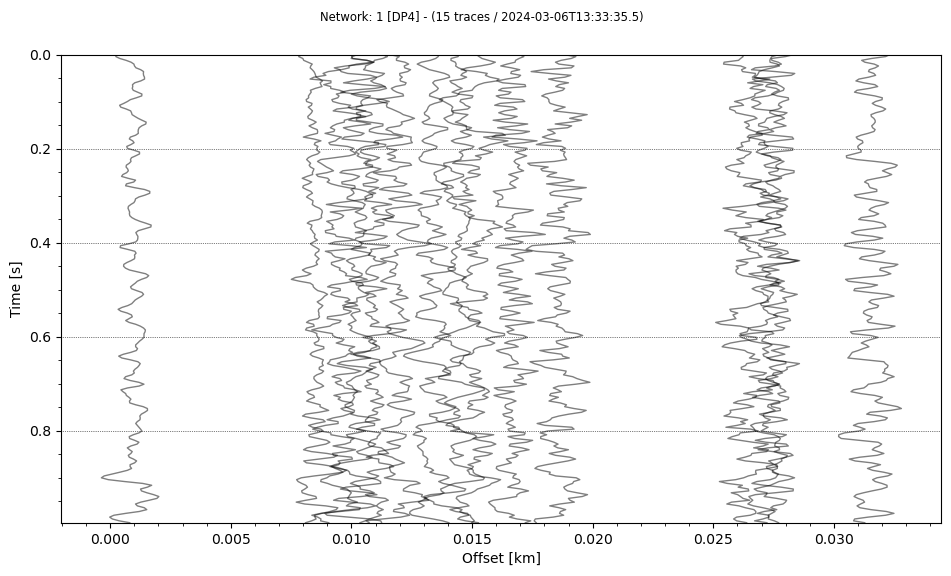

In [238]:

fig_size = (10, 7)  

plt.close('all')

distances = min_dist_source_3

for node_number, tr in enumerate(st_filtered_S3):
    tr.stats.distance = distances[node_number-1] * 1000

st_filtered_S3.plot(type='section', scale=1.0, alpha=0.5,
                    linewidth=1, color='black', show=True,
                    time_down=True,
                    offset='distance', norm_method='trace',
                    figsize=fig_size)  

# Source 4

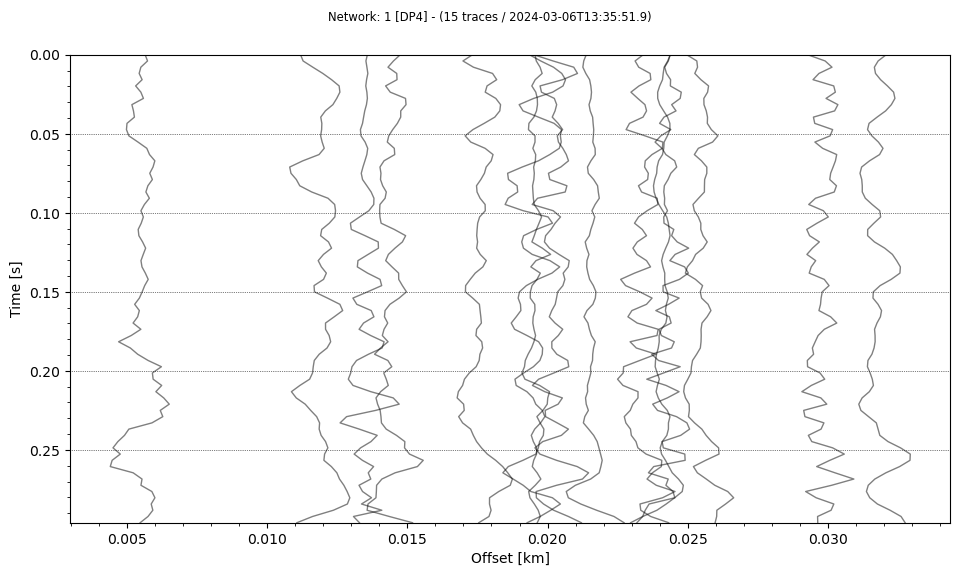

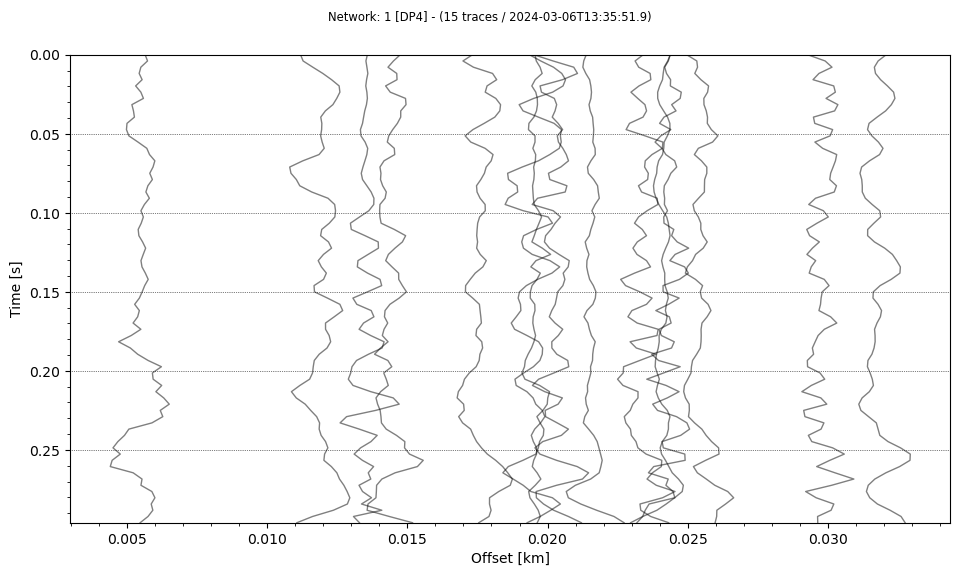

In [241]:

fig_size = (10, 7)  

plt.close('all')

distances = min_dist_source_4

for node_number, tr in enumerate(st_filtered_S4):
    tr.stats.distance = distances[node_number-1] * 1000

st_filtered_S4.plot(type='section', scale=1.0, alpha=0.5,
                    linewidth=1, color='black', show=True,
                    time_down=True,
                    offset='distance', norm_method='trace',
                    figsize=fig_size)  

# Source 5

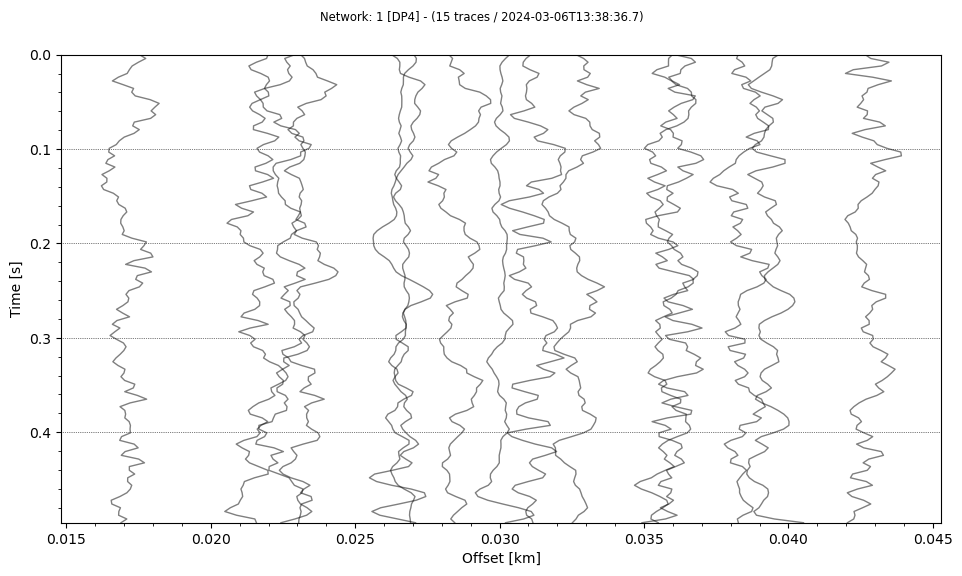

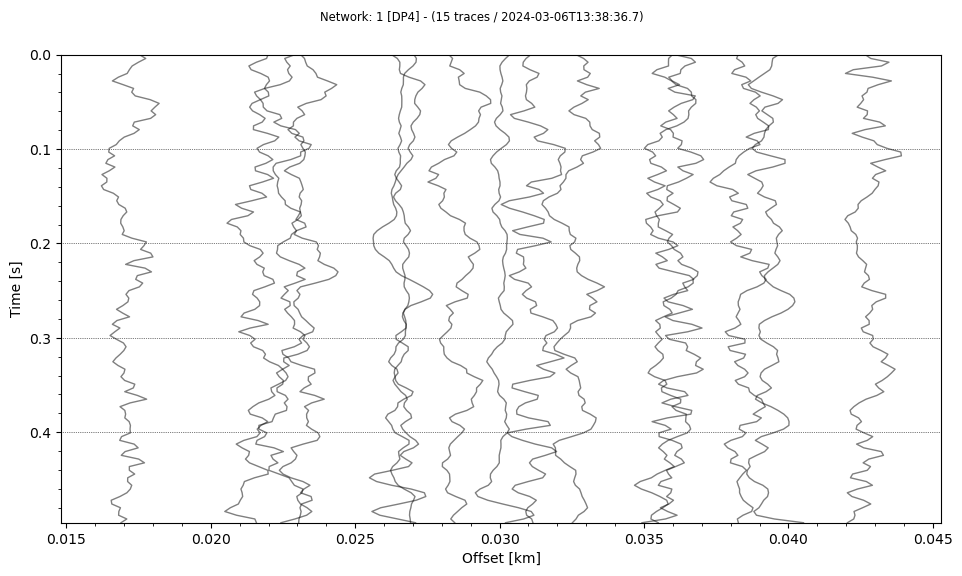

In [245]:

fig_size = (10, 7)  

plt.close('all')

distances = min_dist_source_5

for node_number, tr in enumerate(st_filtered_S5):
    tr.stats.distance = distances[node_number-1] * 1000

st_filtered_S5.plot(type='section', scale=1.0, alpha=0.5,
                    linewidth=1, color='black', show=True,
                    time_down=True,
                    offset='distance', norm_method='trace',
                    figsize=fig_size)  